### Loading Libraries -sklearn

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
%matplotlib inline
import time
import psutil
import os


### Preprocessing Datastet
##### Dividing Feature and Categorical Variables in different lists

In [21]:
def get_system_stats():
    # Get the current CPU usage percentag
    cpu_percent = psutil.cpu_percent(interval=1)
    # Get the current memory usage information
    memory_info = psutil.virtual_memory()

    # Return the CPU usage percentage and the percentage of memory used
    return cpu_percent, memory_info.percent

In [22]:
path = "../../data/mm_master_demos.csv"
master_demo_data = pd.read_csv(path)
len(master_demo_data)

955466

In [23]:
# Define the columns to be dropped from the dataframe
master_demo_data_drop = ['index','file', 'date', 'att_team', 'att_side', 'vic_team', 'att_id', 'vic_id', 'winner_team',
                         'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y', 'avg_match_rank', 'att_rank', 'vic_rank','tick','hitbox','award','wp','is_bomb_planted']

# Drop the defined columns from the dataframe and create a new dataframe 'master_df'
master_df = master_demo_data.drop(master_demo_data_drop, axis=1)

# Define the feature columns for the model
feature_columns = ["map", "round", "seconds", "hp_dmg", "arm_dmg","bomb_site",
                    "wp_type", "winner_side", "round_type", "ct_eq_val", "t_eq_val"]

# Function to identify and return categorical and numerical columns from the dataframe
def identify_column_types(dataframe):
    categorical_cols = dataframe.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
    numerical_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()
    return categorical_cols, numerical_cols

# Identify categorical and numerical columns in 'master_df' using the function 'identify_column_types'
categorical_columns, numerical_columns = identify_column_types(master_df)

# Print the identified categorical and numerical columns
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numerical_columns)

Categorical Columns: ['map', 'vic_side', 'bomb_site', 'wp_type', 'winner_side', 'round_type']
Numerical Columns: ['round', 'seconds', 'hp_dmg', 'arm_dmg', 'ct_eq_val', 't_eq_val']


## Creating a Pipeline
Pipeline will one hot encode the Feature and Categorical Variables for the Random Forest Classifier

In [24]:
categorical_features = ['map','bomb_site', 'wp_type', 'winner_side', 'round_type']  # Define categorical features
numerical_features = ['round', 'seconds', 'hp_dmg', 'arm_dmg', 'ct_eq_val', 't_eq_val']  # Define numerical features


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Pipeline for categorical features: one hot encoding

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])  # Pipeline for numerical features: standard scaling


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),  # Apply numerical transformer to numerical features
        ('cat', categorical_transformer, categorical_features)])  # Apply categorical transformer to categorical features


## Defining Random Forest Classifier (SKLEARN)
##### Create a train,test,val sets. Split is : 70%-train, 10%-val, 20%-test 

In [25]:
rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=10, max_depth=25, random_state=42))])  # Define the pipeline with preprocessor and RandomForestClassifier

X = master_df[feature_columns]  # Define the feature matrix
y = master_df['vic_side']  # Define the target variable

# Split the data into training and testing sets with a test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Grid Search to find best hyperparameters

In [34]:
# param_grid = {
#     'classifier__n_estimators': [10, 50, 100, 200],
#     'classifier__max_depth': [10, 20, 30, 40]
# }
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)

# # Fit the grid search on the training set
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print(f"Best parameters: {grid_search.best_params_}")

# # Evaluate the best model on the validation set
# val_predictions = grid_search.predict(X_val)
# val_accuracy = accuracy_score(y_val, val_predictions)
# print(f"Validation Accuracy: {val_accuracy}")

Best parameters: {'classifier__max_depth': 40, 'classifier__n_estimators': 200}
Validation Accuracy: 0.8534961851235517


## Accuracy on final test set

In [26]:
# best_rf = grid_search.best_estimator_
rf.fit(X_train,y_train)
test_predictions = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Test Accuracy: {test_accuracy}")


Test Accuracy: 0.8287608149595311


### Function that evaluates the code on different number of cores
##### code also records various metrics

In [44]:
def train_evaluate_model2(X_train, y_train, X_test, y_test, cores, trees, maxdepth):
    # Start the timer to measure the execution time
    start_time = time.time()

    # Define the pipeline with two steps:
    # 1. Preprocessing the data using the preprocessor defined earlier
    # 2. Training a RandomForestClassifier with the specified number of trees, maximum depth, and cores
    rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=trees, max_depth=maxdepth, n_jobs=cores))
    ])

    # Fit the pipeline to the training data
    rf.fit(X_train, y_train)
    
    # Predict the target variable for the test set
    test_predictions = rf.predict(X_test)

    # Calculate the time taken to train the model and make predictions
    time_taken_temp = time.time() - start_time

    # Get the current CPU usage percentage
    cpu_usage_temp = psutil.cpu_percent(interval=1)

    # Get the current memory usage percentage
    memory_usage_temp = psutil.virtual_memory()[2]

    # Calculate the accuracy of the model on the test set
    test_accuracy = accuracy_score(y_test, test_predictions)

    # Print the time taken, test accuracy, CPU usage, and memory usage
    print(f"Time taken: {time_taken_temp} seconds")
    print(f"Test Accuracy with {cores} cores: {test_accuracy}")
    print(f"CPU usage: {cpu_usage_temp}%")
    print(f"Memory usage: {memory_usage_temp} %")

    # Append the time taken, CPU usage, and memory usage to their respective lists for later analysis
    time_taken.append(time_taken_temp)
    cpu_usage.append(cpu_usage_temp)
    memory_usage.append(memory_usage_temp)

In [45]:
# Initialize lists to store time taken, CPU usage and memory usage for each iteration
time_taken = []
cpu_usage = []
memory_usage = [] 

# Loop over the number of cores from 1 to 8
for cores in range(1,9):
    # Set the number of trees in the Random Forest
    trees = 10
    # Set the maximum depth of the trees
    maxDepth = 25
    # Call the function to train and evaluate the model with the given parameters
    train_evaluate_model2(X_train, y_train, X_test, y_test, cores, trees, maxdepth =  maxDepth)

Time taken: 143.71834897994995 seconds
Test Accuracy with 1 cores: 0.8282375104660898
CPU usage: 23.5%
Memory usage: 82.7 %
Time taken: 67.8713870048523 seconds
Test Accuracy with 2 cores: 0.8278293329612056
CPU usage: 22.6%
Memory usage: 82.1 %
Time taken: 53.7548451423645 seconds
Test Accuracy with 3 cores: 0.8297516048004465
CPU usage: 21.8%
Memory usage: 81.8 %
Time taken: 46.81805205345154 seconds
Test Accuracy with 4 cores: 0.8279688808261234
CPU usage: 22.2%
Memory usage: 82.0 %
Time taken: 38.426074266433716 seconds
Test Accuracy with 5 cores: 0.8300411666201507
CPU usage: 22.2%
Memory usage: 82.9 %
Time taken: 37.25890779495239 seconds
Test Accuracy with 6 cores: 0.827333938040748
CPU usage: 21.4%
Memory usage: 82.4 %
Time taken: 40.804949045181274 seconds
Test Accuracy with 7 cores: 0.8292666759698577
CPU usage: 47.2%
Memory usage: 82.5 %
Time taken: 48.898792028427124 seconds
Test Accuracy with 8 cores: 0.8284572983533351
CPU usage: 36.6%
Memory usage: 83.1 %


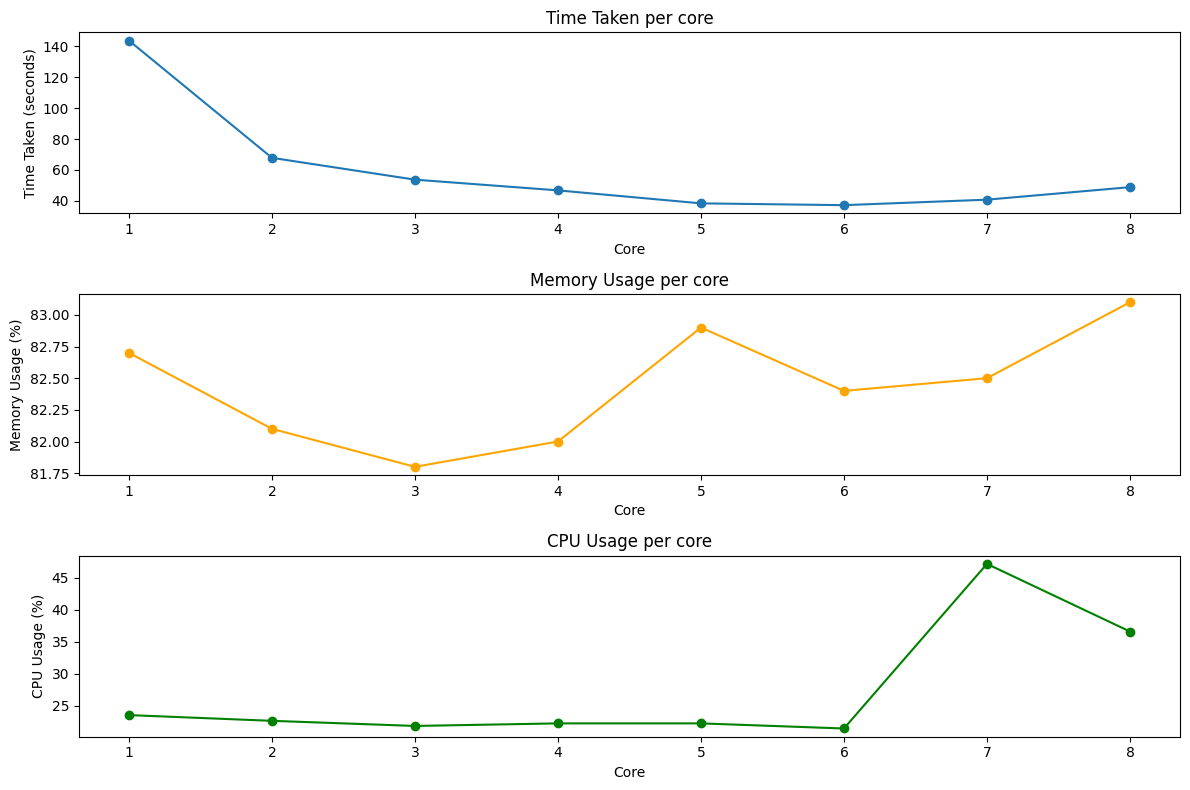

In [47]:
import matplotlib.pyplot as plt

# Create a list of cores
cores = list(range(1, 9))

# Plot time taken for each core
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(cores, time_taken, marker='o')
plt.title('Time Taken per core')
plt.xlabel('Core')
plt.ylabel('Time Taken (seconds)')

# Plot memory usage for each core
plt.subplot(3, 1, 2)
plt.plot(cores, memory_usage, marker='o', color='orange')
plt.title('Memory Usage per core')
plt.xlabel('Core')
plt.ylabel('Memory Usage (%)')

# Plot CPU usage for each core
plt.subplot(3, 1, 3)
plt.plot(cores, cpu_usage, marker='o', color='green')
plt.title('CPU Usage per core')
plt.xlabel('Core')
plt.ylabel('CPU Usage (%)')

plt.tight_layout()
plt.show()

### Relevant Visualizations:

/var/folders/dy/mhvlk_kd13qf_3pc4w8fy0_c0000gn/T/ipykernel_17330/4241235045.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  bomb_planted_vic_side.pivot('is_bomb_planted', 'vic_side', 'counts').plot(kind='bar')


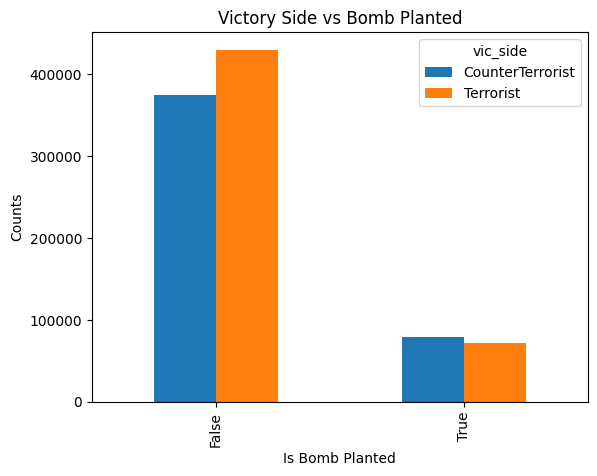

/var/folders/dy/mhvlk_kd13qf_3pc4w8fy0_c0000gn/T/ipykernel_17330/4241235045.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  map_vic_side.pivot('map', 'vic_side', 'counts').plot(kind='bar', stacked=True)


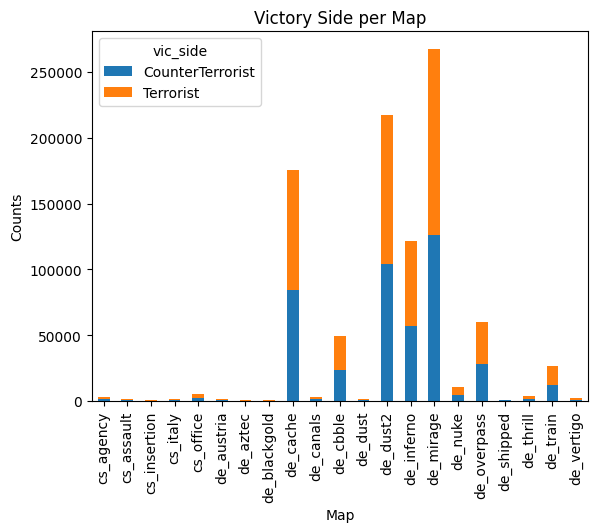

In [27]:
import matplotlib.pyplot as plt
path = "../../data/mm_master_demos.csv"

# Load the data
demo_data = pd.read_csv(path)

# Keep the 'is_bomb_planted' and 'vic_side' columns
master_demo_data_drop = ['index','file', 'date', 'att_team', 'att_side', 'vic_team', 'att_id', 'vic_id', 'winner_team',
                         'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y', 'avg_match_rank', 'att_rank', 'vic_rank','tick','hitbox','award','wp']
mdf2 = demo_data.drop(master_demo_data_drop, axis=1)

# Count the occurrences of each scenario
bomb_planted_vic_side = mdf2.groupby(['is_bomb_planted', 'vic_side']).size().reset_index(name='counts')

# Plot the result
bomb_planted_vic_side.pivot('is_bomb_planted', 'vic_side', 'counts').plot(kind='bar')
plt.title('Victory Side vs Bomb Planted')
plt.xlabel('Is Bomb Planted')
plt.ylabel('Counts')
plt.show()

# Keep the 'map' and 'vic_side' columns
master_demo_data_drop = ['index','file', 'date', 'att_team', 'att_side', 'vic_team', 'att_id', 'vic_id', 'winner_team',
                         'att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y', 'avg_match_rank', 'att_rank', 'vic_rank','tick','hitbox','award','wp', 'is_bomb_planted']
master_df = master_demo_data.drop(master_demo_data_drop, axis=1)

# Count the occurrences of each scenario
map_vic_side = master_df.groupby(['map', 'vic_side']).size().reset_index(name='counts')

# Plot the result
map_vic_side.pivot('map', 'vic_side', 'counts').plot(kind='bar', stacked=True)
plt.title('Victory Side per Map')
plt.xlabel('Map')
plt.ylabel('Counts')
plt.show()